## Data exploration and linear regression in practice

In this section we will start using one of the most well known "Toy" datasets, explore it and select one of the dimensions to learn how to build a linear regression model for its values.
Lets start importing all the libraries (sklearn, seaborn and matplotlib), One of the excellent features of seaborn is the possibility of defining very professional looking style settings, in this case we will use the "whitegrid" style.

In [1]:
import numpy as np
from sklearn import datasets
import seaborn.apionly as sns
%matplotlib inline
import matplotlib.pyplot as plt
sns.set(style='whitegrid', context='notebook')

/usr/local/lib/python2.7/dist-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


### The Iris dataset
It's time to load the Iris dataset. It is one of the most well known historical datasets, you will find it in many books and publications, given the good properties of the data, allowing it to be useful for classification and regression.
The iris dataset (https://archive.ics.uci.edu/ml/datasets/Iris) contains 50 records for each of  three types of Iris flower, 150 lines of total five fields. Each line is a measurement of the following:

Sepal length in cm
Sepal width in cm
Petal length in cm
Petal width in cm

The final field is the type of the flower (setosa, versicolor, or virginica). Let's use the load_dataset method to create an matrix of values from the dataset.

In [2]:
iris2 = sns.load_dataset('iris')

In order to understand the dependency between variables, we will implement the covariance operation. It will receive two arrays as parameters, and will return the covariance(x,y) value.

In [3]:
def covariance (X, Y):
    xhat=np.mean(X)
    yhat=np.mean(Y)
    epsilon=0
    for x,y in zip (X,Y):
        epsilon=epsilon+(x-xhat)*(y-yhat)
    return epsilon/(len(X)-1)

Lets try the implemented function , comparing it with the NumPy one. Note that we calculated cov (a,b), and Numpy generates a matrix of all the conbinations cov(a,a), cov(a,b), so our result should be equals to the values (1,0) and (0,1) of that matrix.

In [4]:
print (covariance ([1,3,4], [1,0,2]))
print (np.cov([1,3,4], [1,0,2]))

0.5
[[ 2.33333333  0.5       ]
 [ 0.5         1.        ]]


Having done a minimal testing of the function correlation function as defined before, recenving two arrays like the covariance, and using it to get the final value

In [5]:
def correlation (X, Y):
    return (covariance(X,Y)/(np.std(X,  ddof=1)*np.std(Y,  ddof=1))) ##We have to indicate ddof=1 the unbiased std

Let's test this function with two sample arrays, and compare with the (0,1) and (1,0) values of the correlation matrix from numpy.

In [6]:
print (correlation ([1,1,4,3], [1,0,2,2]))
print (np.corrcoef ([1,1,4,3], [1,0,2,2]))

0.870388279778
[[ 1.          0.87038828]
 [ 0.87038828  1.        ]]


### Getting an intuitive idea with Seaborn pairplot.

A very good idea when starting working on a problem, is to get a graphical representation of all the possible variable combinations.
Seaborn's pairplot function brings a very complete graphical summary of all the variable pairs, represented as scatterplots, and a representation of the univariate distribution for the matrix diagonal.
Let's look at how this plot type shows all the variables dependencies, and try to look for a relationship wich resembles of a linear one, to have as a base to test our regression metods.

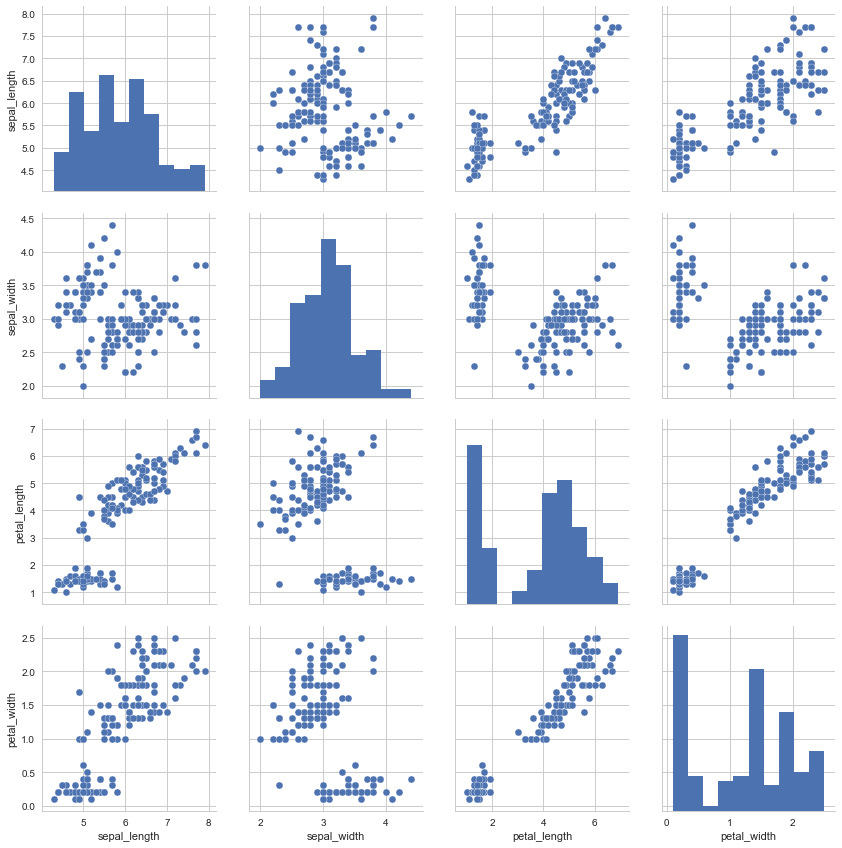

In [7]:
sns.pairplot(iris2, size=3.0)

Lets select two varibles which from our initial analysis, have the property of being linearly dependent, they are petal_width and petal_length.

In [8]:
X=iris2['petal_width']
Y=iris2['petal_length']

Let's now take a look at this varible conbination, which shows a clear linear tendency.

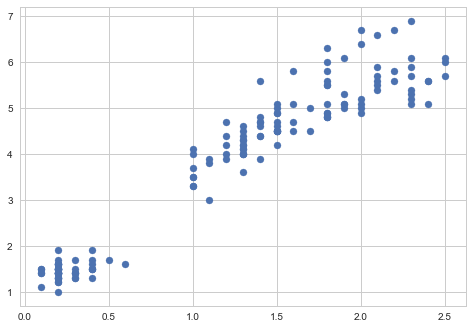

In [9]:
plt.scatter(X,Y)

### Creating the prediction function
First lets define the function which will abstractely represent the modeled data, in the form of a linear function, with the form y=beta*x+alpha

In [10]:
def predict(alpha, beta, x_i):
    return beta * x_i + alpha

### Defining the error function
It's now time to define the function which will show us the error from our predictions to the correct one during training. As we will explain more in depth in the following chapter,  we have two main alternatives, measuring the absolute difference between the values (or L1), or measuring a variant of the square of the difference (or L2). Let's define both versions of them, including the first formulation inside the second.

In [11]:
def error(alpha, beta, x_i, y_i): #L1
    return y_i - predict(alpha, beta, x_i)

def sum_sq_e(alpha, beta, x, y): #L2
    return sum(error(alpha, beta, x_i, y_i) ** 2
               for x_i, y_i in zip(x, y))

### Correlation fit
Now we will define a function implementing the correlation method to find the parameters for our regression

In [12]:
def correlation_fit(x, y):
    beta = correlation(x, y) * np.std(y, ddof=1) / np.std(x,ddof=1)
    alpha = np.mean(y) - beta * np.mean(x)
    return alpha, beta

Let's then run the fitting function, and print the guessed parameters

In [13]:
alpha, beta = correlation_fit(X, Y)
print(alpha)
print(beta)

1.08355803285
2.22994049512


Let's now graph the regressed line with the data, to intuitively show the appropiateness of the solution.

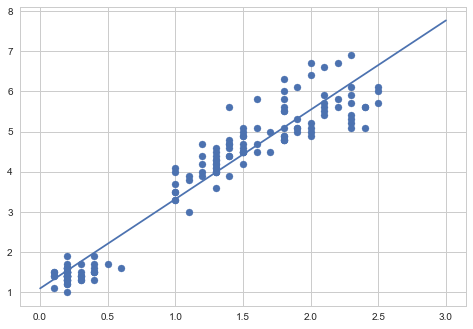

In [14]:
plt.scatter(X,Y)
xr=np.arange(0,3.5)
plt.plot(xr,(xr*beta)+alpha)

### Polynomial regression and introduction to underfitting and overfitting

When looking for a model, one of the main characteristics we look after is the power of generalyzing with a simple functional expression.
When we increase the complexity of the model, its possible that we are building a model too good for the training data, but will be too optimized for that particular subset of data.

Underfitting, on the other hand, applies to the situations where the model is too simple, as this case can be represented fairly well with a simple linear model.

In the following example we will work on the same problem as before, usinge sklearn library to search higher order polynomials to fit the incoming data, with increasingly complex degrees.

Going beyond the normal threshold of a quadratic function, we will see how the function looks to fit for every wrinkle in the data, but when we extrapolate, the values outside the normal range are clearly out of range:

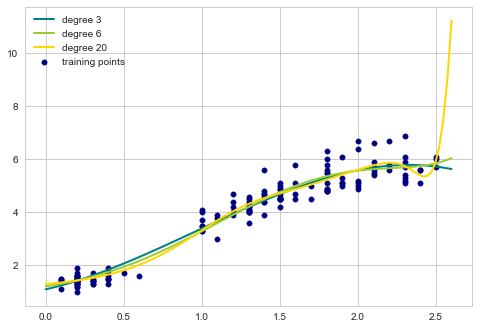

In [49]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

ix=iris2['petal_width']
iy=iris2['petal_length']

# generate points used to represent the fitted function 
x_plot = np.linspace(0, 2.6, 100)

# create matrix versions of these arrays
X = ix[:, np.newaxis]
X_plot = x_plot[:, np.newaxis]

plt.scatter(ix, iy, s=30, marker='o', label="training points")

for count, degree in enumerate([3, 6, 20]):
    model = make_pipeline(PolynomialFeatures(degree), Ridge())
    model.fit(X, iy)
    y_plot = model.predict(X_plot)
    plt.plot(x_plot, y_plot, label="degree %d" % degree)

plt.legend(loc='upper left')

plt.show()